In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

In [2]:
from tensorflow.math import maximum, minimum

class PreisachMemoryLayer(tf.keras.layers.Layer):
    def __init__(self, n_operators, batch_size, **kwargs):
        super(PreisachMemoryLayer, self).__init__(name=f"PreisachMemoryLayer_{batch_size}", **kwargs)
        self.batch_size = batch_size
        self.n_operators = n_operators
        self.first_batch = True
    
    def build(self, input_shape):
        self.input_dim = input_shape
        self.play_operators = tf.Variable(initial_value=tf.zeros((input_shape[0], input_shape[1], self.n_operators)), trainable=False)
        self.prev_play_operators = tf.Variable(initial_value=tf.zeros((input_shape[0], self.n_operators)), trainable=False) 
        self.r = np.zeros(self.n_operators)
        
        for j in range(self.n_operators):
            # Since the input signal is normalized between -1 and 1, these are also min and max
            self.r[j] = (j / self.n_operators) * (1 - (-1))
        
    def call(self, inputs):
        for t in range(self.input_dim[1]):
            for j in range(self.n_operators):
                if t == 0:
                    if self.first_batch:
                        self.play_operators[:, t, j].assign(maximum(inputs[:, t,] - self.r[j], minimum(inputs[:, t,] + self.r[j], 0))) 
                    else:
                        self.play_operators[:, t, j].assign(maximum(inputs[:, t,] - self.r[j], minimum(inputs[:, t,] + self.r[j], self.prev_play_operators[:, j])))
                else:
                    self.play_operators[:, t, j].assign(maximum(inputs[:, t,] - self.r[j], minimum(inputs[:, t,] + self.r[j], self.play_operators[:, t - 1, j])))
                
        if self.first_batch:
            self.first_batch = False
        
        self.prev_play_operators.assign(self.play_operators[:, t, :])
        
        # The following comment is used as a reference for the Play Operators definition
        # P_j(t) = max(u(t) - r_j, min(u(t) + r_j, P_j(t - 1)))
        # P_j(0) = max(u(0) - r_j, min(u(0) + r_j, k0))
        # r_j = (j - 1)/n * (max(u(t)) - min(u(t)))  j = 1, ..., n
        
        return self.play_operators

In [3]:
# Defining some of the Network and Sequence parameters:
# For training purposes, the sequence length is fixed to 20
seq_len = 20
batch_size = 10

# To have cross-batch statefulness set stateful = True
stateful = True

Model: "PreisachRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H (InputLayer)                 [(10, 20, 1)]        0           []                               
                                                                                                  
 H_dot (InputLayer)             [(10, 20, 1)]        0           []                               
                                                                                                  
 PreisachMemoryLayer_10 (Preisa  (10, 20, 6)         1260        ['H[0][0]']                      
 chMemoryLayer)                                                                                   
                                                                                                  
 concatenate (Concatenate)      (10, 20, 8)          0           ['H[0][0]',            

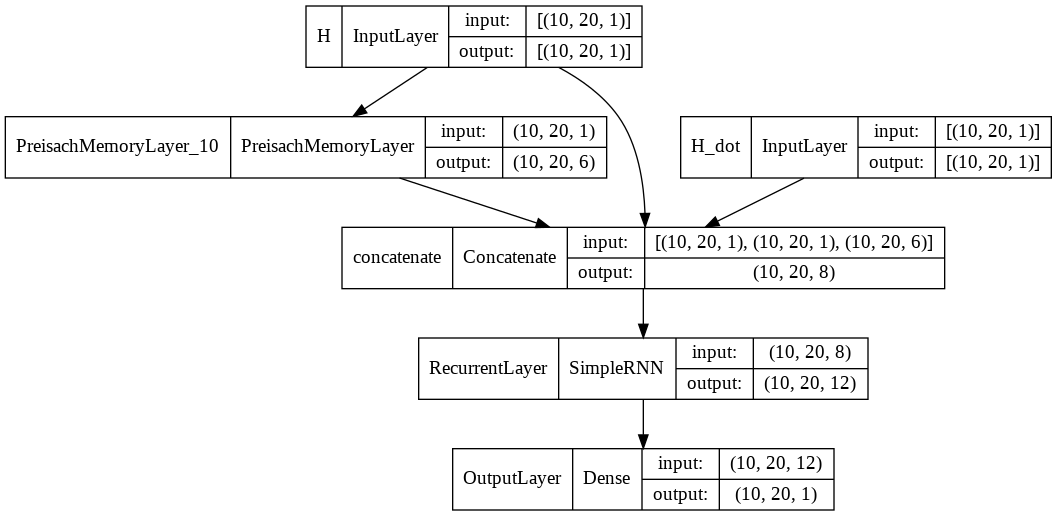

In [4]:
# Example: building a PreisachRNN using the custom Layer to implement Preisach Memory 

# Setting the number of Play Operators to be used by the model
n_operators = 6
rnn_units = 12

H = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size, name='H')
H_dot = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size, name='H_dot')

preisach_layer = PreisachMemoryLayer(n_operators=n_operators, batch_size=batch_size)(H)

concatenate = tf.keras.layers.concatenate([H, H_dot, preisach_layer])

recurrent_layer = tf.keras.layers.SimpleRNN(units=rnn_units, return_sequences=True, stateful=stateful, name='RecurrentLayer')(concatenate)
outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(recurrent_layer)


model = tf.keras.Model(inputs=[H, H_dot], outputs=outputs, name='PreisachRNN')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)